# BERTopic Short Demo

### Read and Preprocess Data

In [1]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

# this is a function from sklearn that fetches the 20 newsgroups text dataset
# it is a collection of approximately 20,000 newsgroup documents, partitioned across 20 different newsgroups
# this returns a bunch object, which is very similar to a dictionary
bunch = fetch_20newsgroups(
    categories=["comp.graphics", "rec.autos", "rec.motorcycles", 
                "rec.sport.baseball", "rec.sport.hockey", 
                "sci.electronics", "sci.med", "sci.space"], # only extract select topics
    remove=("headers","footers","quotes")) # don't extract unnecessary metadata

# get the text data and labels
docs = bunch["data"]
doc_labels = bunch["target"]

print("Documents: ")
print(docs[:5])

# create a data frame with the text and labels
df = pd.DataFrame({
    "text": docs,
    "labels": doc_labels
})

# create a label with text info
df["labels_text"] = df["labels"].astype("category").cat.rename_categories({i:j for i,j in enumerate(bunch["target_names"])})

print()
print("Data Frame: ")
print(df.head())

Documents: 
['\nCONGRAULATIONS !!!! Your helmet just passed the Snell Test.\n \n\nOh well, as least it looks ok now. Still, it may not save your head as well\nas before you dropped it.\n\nMike', "SP> From: paulson@tab00.larc.nasa.gov (Sharon Paulson)\nSP> to describe here.  I have a fourteen year old daugter who experienced\nSP> a seizure on November 3, 1992 at 6:45AM after eating Kellog's Frosted\nSP> Flakes.\n\nSP> Well, we were going along fine and the other morning, April 5, she had\nSP> a bowl of another Kellog's frosted kind of cereal, Fruit Loops (I am\n\nSP> When I mentioned what she ate the first time as a possible reason for\nSP> the seizure the neurologist basically negated that as an idea.  Now\nSP> after this second episode, so similar in nature to the first, even\nSP> he is scratching his head.\n\nThere's no data that sugar-coated cereals cause seizures.  I haven't\neven seen anything anecdotal on it.  Given how common they are eaten\n- do you know any child or adolescent

Before applying topic modeling to the text, we should do a basic preprocessing, mainly stripping of newlines and removing empty texts.

In [2]:
# strip blank characters
df["text_processed"] = df["text"].str.strip()

# remove empty text from data frame
empty_text_bool =  df["text_processed"].str.len() == 0

print(f"Number of empty texts: {empty_text_bool.sum()}")

# remove empty text from df
df = df[~empty_text_bool]

print("Final Data Frame:")
print(f"Dimension: {df.shape[0]}, {df.shape[1]}")
df.head()

Number of empty texts: 145
Final Data Frame:
Dimension: 4606, 4


,text,labels,labels_text,text_processed
0,\nCONGRAULATIONS !!!! Your helmet just passed ...,2,rec.motorcycles,CONGRAULATIONS !!!! Your helmet just passed th...
1,SP> From: paulson@tab00.larc.nasa.gov (Sharon ...,6,sci.med,SP> From: paulson@tab00.larc.nasa.gov (Sharon ...
2,"Dear Binary Newsers,\n\nI am looking for Quick...",0,comp.graphics,"Dear Binary Newsers,\n\nI am looking for Quick..."
3,"Thanks to aldridge@netcom.com, I now know a bi...",6,sci.med,"Thanks to aldridge@netcom.com, I now know a bi..."
4,Are there significant differences between V2.0...,0,comp.graphics,Are there significant differences between V2.0...


In [3]:
# store the texts into docs variable
docs = df["text_processed"].values.tolist()

In [4]:
print(docs[:5])

['CONGRAULATIONS !!!! Your helmet just passed the Snell Test.\n \n\nOh well, as least it looks ok now. Still, it may not save your head as well\nas before you dropped it.\n\nMike', "SP> From: paulson@tab00.larc.nasa.gov (Sharon Paulson)\nSP> to describe here.  I have a fourteen year old daugter who experienced\nSP> a seizure on November 3, 1992 at 6:45AM after eating Kellog's Frosted\nSP> Flakes.\n\nSP> Well, we were going along fine and the other morning, April 5, she had\nSP> a bowl of another Kellog's frosted kind of cereal, Fruit Loops (I am\n\nSP> When I mentioned what she ate the first time as a possible reason for\nSP> the seizure the neurologist basically negated that as an idea.  Now\nSP> after this second episode, so similar in nature to the first, even\nSP> he is scratching his head.\n\nThere's no data that sugar-coated cereals cause seizures.  I haven't\neven seen anything anecdotal on it.  Given how common they are eaten\n- do you know any child or adolescent who *doesn't*

### Simplest case

BERTopic can be run out of the box without any tuning. However, this doesn't guarantee the best number of topics and representation for each topic.

In [31]:
from bertopic import BERTopic

topic_model = BERTopic() # initialize the model
topic_model.fit(docs) # fit the model to the data

topic_model.get_topic_info() # get the topic information

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1495,-1_the_and_to_of,"[the, and, to, of, is, for, in, you, it, on]",[Archive-name: rec-autos/part1\n\n[most recent...
1,0,468,0_he_his_the_year,"[he, his, the, year, in, that, and, to, was, but]","[Oh, yeah. Dave Winfield--marginal player. G..."
2,1,367,1_team_the_he_25,"[team, the, he, 25, hockey, play, in, period, ...",[Individual leaders by total points (Final sta...
3,2,140,2_car_cars_the_engine,"[car, cars, the, engine, it, you, and, that, f...",[[stuff about autobahn and safety of sho at sp...
4,3,133,3_you_joke_was_deleted,"[you, joke, was, deleted, your, im, to, if, yo...","[Pete Young, on the Tue, 20 Apr 93 08:29:21 GM..."
...,...,...,...,...,...
67,66,11,66_mask_it_face_logo,"[mask, it, face, logo, goalies, forehead, goal...",[It would seem logical that the mask is Potvin...
68,67,11,67_weight_fat_eating_eat,"[weight, fat, eating, eat, my, dieting, obesit...",[In fact Adiposity 101 mentions a similar stud...
69,68,11,68_cview_temp_file_files,"[cview, temp, file, files, floppy, disk, direc...",[: >over where it places its temp files: it ju...
70,69,11,69_shaft_wheelie_shaftdrive_wheelies,"[shaft, wheelie, shaftdrive, wheelies, rear, e...","[: \n: >I bought it, I tried it:\n: \n: >It is..."


### Embeddings

In [5]:
from sentence_transformers import SentenceTransformer

# initialize model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2") # all-MiniLM-L6-v2 is name of pretrained model
embeddings = embedding_model.encode(docs) # encode the texts into embeddings

In [7]:
print("Dimension of embeddings: ")
print(embeddings.shape)
print()
print(embeddings)

Dimension of embeddings: 
(4606, 384)

[[-0.00213908  0.04308949  0.05013822 ... -0.01613711 -0.02208866
   0.07706439]
 [-0.03420202 -0.08700941  0.02444808 ...  0.03278657 -0.0257326
   0.05272757]
 [-0.0135803  -0.02875871 -0.05647386 ...  0.06592873  0.00590129
  -0.01697435]
 ...
 [-0.06831513  0.04242567  0.02433794 ...  0.05475036 -0.03422438
   0.02065529]
 [-0.03812822 -0.02588745 -0.11860324 ...  0.0786099  -0.00089193
   0.04407   ]
 [-0.02731518  0.05332442  0.06714313 ... -0.04175352 -0.09743449
   0.00926422]]


### Dimension Reduction

In [8]:
from umap import UMAP
import umap.plot

# set random seed for reproducibility
seed = 54382
# initialize UMAP model
umap_model = UMAP(n_components=2, n_neighbors = 15, metric="cosine", random_state=seed)
# fit the UMAP model to find the best 2D representation of the embeddings
umap_model.fit(embeddings)

c:\Users\xtc3853\AppData\Local\miniforge3\envs\nlp-practice\Lib\site-packages\numba\np\ufunc\dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
c:\Users\xtc3853\AppData\Local\miniforge3\envs\nlp-practice\Lib\site-packages\numba\np\ufunc\dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
c:\Users\xtc3853\AppData\Local\miniforge3\envs\nlp-practice\Lib\site-packages\numba\np\ufunc\dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a 

UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, random_state=54382, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [9]:
print("Dimension of UMAP output: ")
print(umap_model.embedding_.shape)

Dimension of UMAP output: 
(4606, 2)


c:\Users\xtc3853\AppData\Local\miniforge3\envs\nlp-practice\Lib\site-packages\umap\plot.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

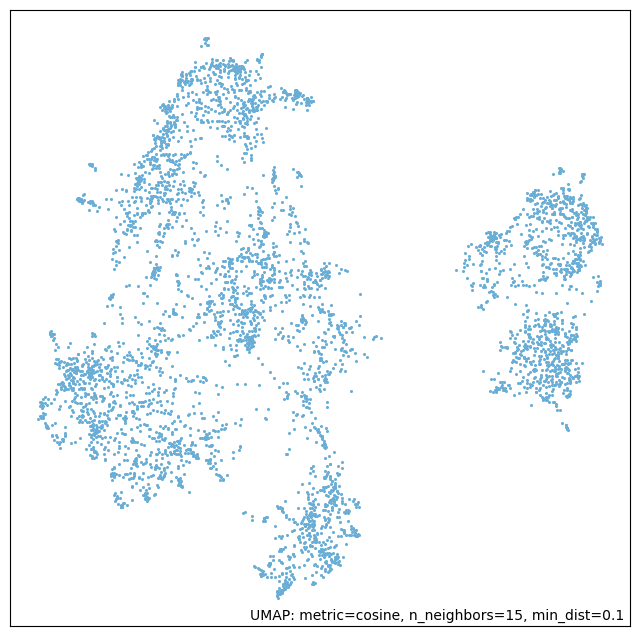

In [10]:
# Plot the UMAP representation
umap.plot.points(umap_model)

### Unsupervised Clustering

c:\Users\xtc3853\AppData\Local\miniforge3\envs\nlp-practice\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xtc3853\AppData\Local\miniforge3\envs\nlp-practice\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

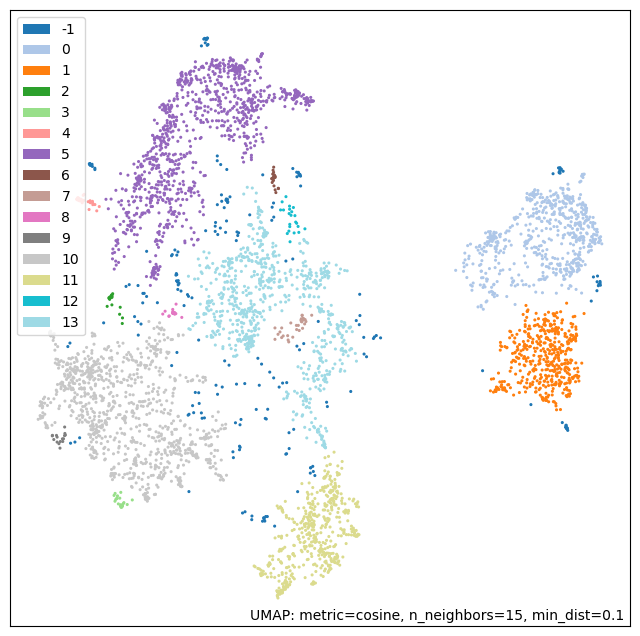

In [24]:
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt

# initialize HDBSCAN model
hdbscan_model = HDBSCAN(min_cluster_size=15, min_samples=1, cluster_selection_epsilon=0.165)

# identify clusters on the 2-d representation of embeddings generated by UMAP
hdbscan_model.fit(umap_model.embedding_)
umap.plot.points(umap_model, labels=hdbscan_model.labels_, theme="blue")

### Labeling

In [29]:
from keybert import KeyBERT
import numpy as np

# initialize the model; can use the same LM as we used for embeddings
rep_model = KeyBERT(model='all-MiniLM-L6-v2')

# loop through the clusters and get the labels (as BERTopic would do)
for label in np.unique(hdbscan_model.labels_):
    # Get docs in this cluster
    cluster_docs = [doc for doc, c in zip(docs, hdbscan_model.labels_) if c == label]
    # Combine documents into a single string
    combined_text = ' '.join(cluster_docs)
    # Extract keywords
    keywords = rep_model.extract_keywords(combined_text, top_n=5)
    # print the results 
    # Note: KeyBERT returns a tuple with the (word, numer), where the number is:
    #   the relevance score, i.e., the cosine similarity between the embedding of the keyword and the original doc
    print(label, [kw[0] for kw in keywords])

-1 ['bikes', 'motorcycles', 'discount', 'interstates', 'insurance']
0 ['mets', 'jerseys', 'uniforms', 'baseballers', 'mlb']
1 ['pitches', 'pitching', 'inning', 'hitters', 'innings']
2 ['mileage', 'odometers', 'tripmeter', 'odometer', 'speedometer']
3 ['helmet', 'helmetted', 'helmeted', 'helmets', 'dropped']
4 ['telephone', 'caller', 'dial', 'covingtontelephone', 'handset']
5 ['radiosity_code', 'photodiode', 'decoder', 'image32', 'imagestudio']
6 ['archives', 'archive', 'archiving', 'digitised', 'photographs']
7 ['wrights', 'wright', 'wilbur', 'wrightwatson', 'aerospace']
8 ['hourglass', 'turbines', 'turbine', 'boilers', 'powerplant']
9 ['insurance', 'insured', 'rates', 'rate', '300hp']
10 ['400s', '400cc', '500cc', 'k100rs', '750cc']
11 ['seizures', 'cereal', 'cereals', 'seizure', 'epilepsy']
12 ['conic', 'fortran', 'rr', 'petrossian', 'illustrated']
13 ['costs', 'redesigning', 'budget', 'cost', 'spaceflight']


## Combine All Steps with BERTopic

In [ ]:
from bertopic.representation import KeyBERTInspired

# set random seed for reproducibility
seed = 54382

# embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2") # all-MiniLM-L6-v2 is name of pretrained model

# umap model
umap_model = UMAP(n_components=2, n_neighbors = 15, metric="cosine", random_state=seed)

# initialize HDBSCAN model
hdbscan_model = HDBSCAN(min_cluster_size=15, min_samples=1, cluster_selection_epsilon=0.165)

# representation model
representation_model = KeyBERTInspired()

# define the BERTopic model using the models above
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    verbose=True
)

# fit the model to the data
topic_model.fit(docs) 

# get the topic information
topic_model.get_topic_info() 

2025-05-16 12:11:30,549 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/144 [00:00<?, ?it/s]

2025-05-16 12:11:37,750 - BERTopic - Embedding - Completed ✓
2025-05-16 12:11:37,751 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
c:\Users\xtc3853\AppData\Local\miniforge3\envs\nlp-practice\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
2025-05-16 12:11:42,577 - BERTopic - Dimensionality - Completed ✓
2025-05-16 12:11:42,578 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-16 12:11:42,630 - BERTopic - Cluster - Completed ✓
2025-05-16 12:11:42,633 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-05-16 12:11:43,675 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,230,-1_cview_jagr_neutral_grounding,"[cview, jagr, neutral, grounding, temp, wire, ...","[[Newsgroups: m.h.a added, followups set to mo..."
1,0,966,0_graphics_get_computer_software,"[graphics, get, computer, software, at, what, ...",[OpenGL is a graphics programming library and ...
2,1,951,1_road_miles_drive_car,"[road, miles, drive, car, cars, bike, what, ab...",[My knowledge about driving in the U.S. is als...
3,2,739,2_nasa_spacecraft_space_satellite,"[nasa, spacecraft, space, satellite, shuttle, ...",[Archive-name: space/references\nLast-modified...
4,3,602,3_nhl_puck_flyers_hockey,"[nhl, puck, flyers, hockey, league, players, s...","[Apparently, Part 2 (defensemen numbered 2 thr..."
5,4,477,4_patients_medical_disease_medicine,"[patients, medical, disease, medicine, doctor,...",[------------- cut here -----------------\n\n\...
6,5,455,5_pitching_pitcher_hitter_braves,"[pitching, pitcher, hitter, braves, sox, cubs,...",[So far Simmons looks like a total idiot.\n\n\...
7,6,34,6_newsgroup_groups_group_split,"[newsgroup, groups, group, split, forum, discu...","[Concerning the proposed newsgroup split, I pe..."
8,7,32,7_telephone_dial_call_phone,"[telephone, dial, call, phone, telco, line, li...",[AL>> Question: Is there a certain de...
9,8,24,8_helmet_helmets_fiberglass_impact,"[helmet, helmets, fiberglass, impact, bike, he...",[This is not good advice. A couple of years I...


2025-05-15 16:29:23,594 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/144 [00:00<?, ?it/s]

2025-05-15 16:29:30,742 - BERTopic - Embedding - Completed ✓
2025-05-15 16:29:30,742 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-15 16:29:35,166 - BERTopic - Dimensionality - Completed ✓
2025-05-15 16:29:35,167 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-15 16:29:35,224 - BERTopic - Cluster - Completed ✓
2025-05-15 16:29:35,227 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-05-15 16:29:35,513 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,230,-1_ground_captain_traded_time,"[ground, captain, traded, time, neutral, know,...",[They require two separate grounds. One groun...
1,0,966,0_image_use_jpeg_graphics,"[image, use, jpeg, graphics, does, file, need,...",[Printer model and specification:\n\nCanon CLC...
2,1,951,1_car_bike_just_like,"[car, bike, just, like, cars, don, engine, goo...",[My knowledge about driving in the U.S. is als...
3,2,739,2_space_nasa_launch_earth,"[space, nasa, launch, earth, orbit, edu, shutt...",[COMMERCIAL SPACE NEWS/SPACE TECHNOLOGY INVEST...
4,3,602,3_team_game_hockey_55,"[team, game, hockey, 55, 25, play, 10, 11, sea...","[Well, I'm back from Tokyo, so here are the st..."
5,4,477,4_medical_food_disease_doctor,"[medical, food, disease, doctor, people, pain,...",[------------- cut here -----------------\nUni...
6,5,455,5_year_00_game_team,"[year, 00, game, team, hit, runs, 02, players,...",[I am trying to think how to respond to this w...
7,6,34,6_com_edu_graphics_group,"[com, edu, graphics, group, cs, comp, groups, ...","[: Concerning the proposed newsgroup split, I ..."
8,7,32,7_phone_number_hook_line,"[phone, number, hook, line, telephone, led, al...",[Up to 60 microamperes = on hook\n\nOver so...
9,8,24,8_helmet_cb_head_shell,"[helmet, cb, head, shell, impact, bike, face, ...",[CB> DON'T BE SO STUPID AS TO LEAVE YOU...
